In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# import os
# from google.colab import drive

# os.makedirs('/content', exist_ok=True)
# drive.mount('/content/drive')

# Data Preparation

In [3]:
df = pd.read_csv("C:/Users/PC/Downloads/zurich.csv")
print(f"Initial data shape: {df.shape}")

Initial data shape: (3425002, 8)


In [3]:
df.isnull().sum()

day               0
interval          0
detid             0
flow              0
occ               0
error             0
city              0
speed       3425002
dtype: int64

In [4]:
df.head(20)

,day,interval,detid,flow,occ,error,city,speed
0,2015-10-26,180,K10D11,40.0,0.005556,0.0,zurich,NaN
1,2015-10-26,360,K10D11,0.0,0.000000,0.0,zurich,NaN
2,2015-10-26,540,K10D11,40.0,0.007778,0.0,zurich,NaN
3,2015-10-26,720,K10D11,40.0,0.008333,0.0,zurich,NaN
4,2015-10-26,900,K10D11,0.0,0.000000,0.0,zurich,NaN
5,2015-10-26,1080,K10D11,40.0,0.007778,0.0,zurich,NaN
6,2015-10-26,1260,K10D11,40.0,0.005000,0.0,zurich,NaN
7,2015-10-26,1440,K10D11,0.0,0.000000,0.0,zurich,NaN
8,2015-10-26,1620,K10D11,20.0,0.003333,0.0,zurich,NaN
9,2015-10-26,1800,K10D11,60.0,0.011111,0.0,zurich,NaN


In [5]:
df['day'] = pd.to_datetime(df['day'], format="%Y-%m-%d")

## Analisis Nilai Hilang

In [6]:
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)

missing_data = pd.DataFrame({
    'Total Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_data = missing_data[missing_data['Total Missing Values'] > 0].sort_values(by='Total Missing Values', ascending=False)

print("Analisis Nilai Hilang:")
print(missing_data)

Analisis Nilai Hilang:
       Total Missing Values  Percentage
speed               3425002       100.0


In [7]:
df = df.drop(columns=['speed'], errors='ignore')

In [8]:
df = df.drop_duplicates()

In [9]:
df = df[(df['flow'] >= 0) & (df['occ'] >= 0)]

## Statistik Deskriptif

In [10]:
print("Statistik Deskriptif untuk Kolom Numerik Terpilih:")
print(df[['flow', 'occ', 'interval', 'error']].describe())

Statistik Deskriptif untuk Kolom Numerik Terpilih:
               flow           occ      interval         error
count  3.425002e+06  3.425002e+06  3.425002e+06  3.425002e+06
mean   2.074920e+02  1.000321e-01  4.312433e+04  2.170510e-03
std    2.031532e+02  1.632819e-01  2.493403e+04  4.653815e-02
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    4.000000e+01  8.333334e-03  2.160000e+04  0.000000e+00
50%    1.400000e+02  3.333333e-02  4.320000e+04  0.000000e+00
75%    3.200000e+02  1.100000e-01  6.480000e+04  0.000000e+00
max    6.240000e+03  2.833556e+01  8.622000e+04  1.000000e+00


## Outlier clipping (Extreme)

In [11]:
q1 = df['flow'].quantile(0.01)
q99 = df['flow'].quantile(0.99)
df['flow_clip'] = df['flow'].clip(q1, q99)

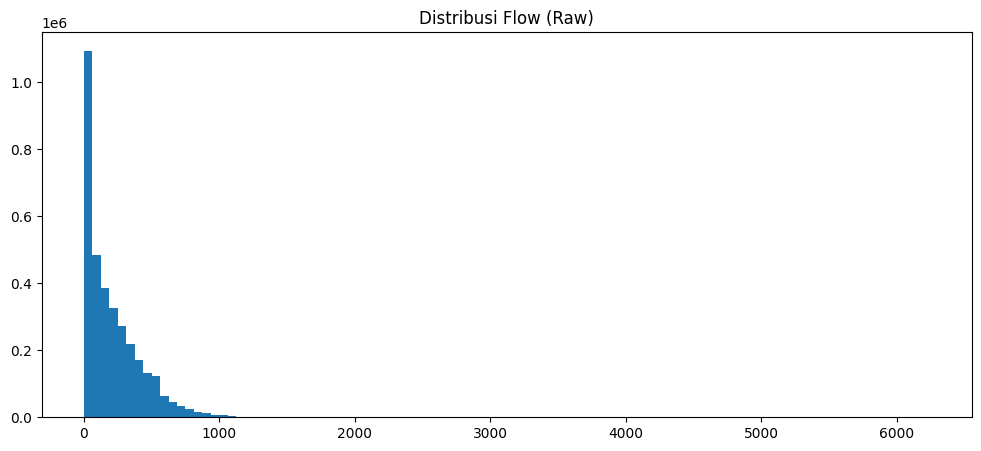

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.hist(df['flow'], bins=100)
plt.title("Distribusi Flow (Raw)")
plt.show()

Log Transform (Buat dist heavy right tail) karena data sangat skewed ke kanan

In [13]:
df['flow_log'] = np.log1p(df['flow'])

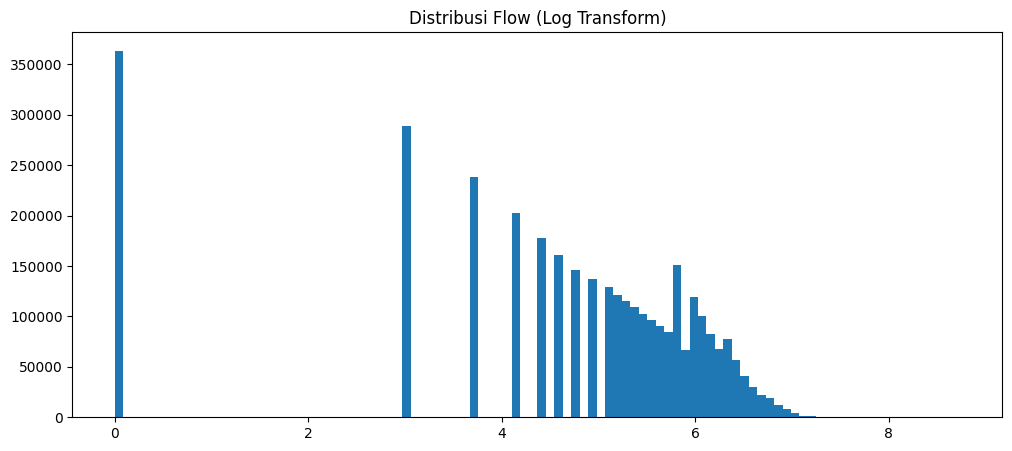

In [14]:
plt.figure(figsize=(12,5))
plt.hist(df['flow_log'], bins=100)
plt.title("Distribusi Flow (Log Transform)")
plt.show()


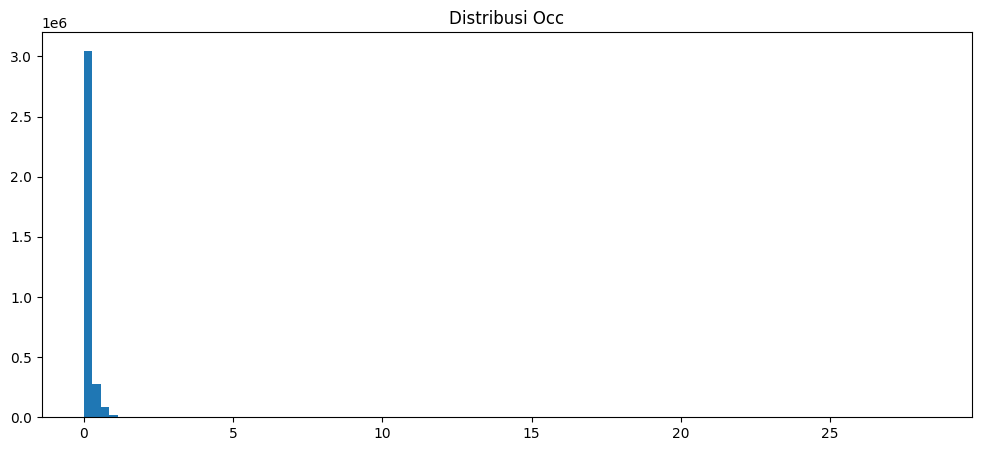

In [15]:
plt.figure(figsize=(12,5))
plt.hist(df['occ'], bins=100)
plt.title("Distribusi Occ")
plt.show()

In [16]:
df['occ_log'] = np.log1p(df['occ'])

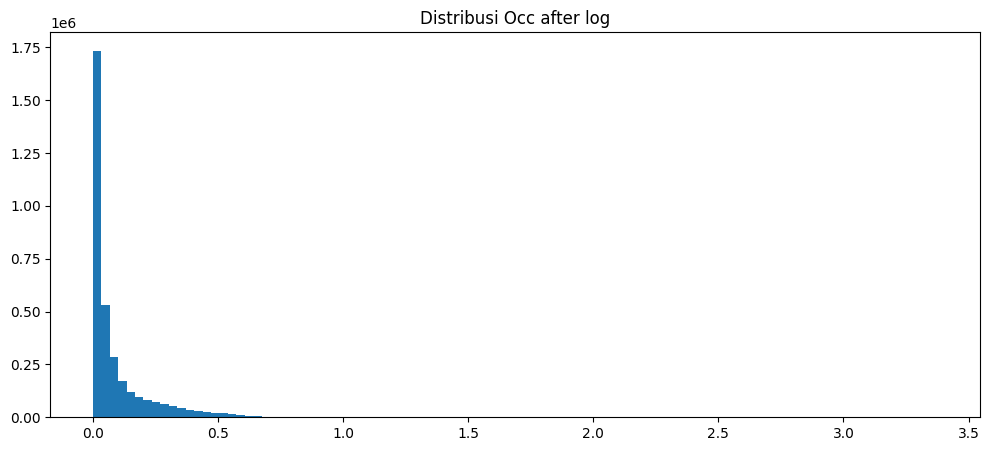

In [17]:
plt.figure(figsize=(12,5))
plt.hist(df['occ_log'], bins=100)
plt.title("Distribusi Occ after log")
plt.show()

## Deteksi Outlier pada 'flow' menggunakan IQR

In [18]:
Q1 = df['flow'].quantile(0.25)
Q3 = df['flow'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_flow = df[(df['flow'] < lower_bound) | (df['flow'] > upper_bound)]

print(f"Q1 (flow): {Q1}")
print(f"Q3 (flow): {Q3}")
print(f"IQR (flow): {IQR}")
print(f"Lower Bound (flow): {lower_bound}")
print(f"Upper Bound (flow): {upper_bound}")
print(f"Number of outliers in 'flow': {len(outliers_flow)}")

Q1 (flow): 40.0
Q3 (flow): 320.0
IQR (flow): 280.0
Lower Bound (flow): -380.0
Upper Bound (flow): 740.0
Number of outliers in 'flow': 76119


In [19]:
Q1_occ = df['occ'].quantile(0.25)
Q3_occ = df['occ'].quantile(0.75)
IQR_occ = Q3_occ - Q1_occ

lower_bound_occ = Q1_occ - 1.5 * IQR_occ
upper_bound_occ = Q3_occ + 1.5 * IQR_occ

outliers_occ = df[(df['occ'] < lower_bound_occ) | (df['occ'] > upper_bound_occ)]

print(f"Q1 (occ): {Q1_occ}")
print(f"Q3 (occ): {Q3_occ}")
print(f"IQR (occ): {IQR_occ}")
print(f"Lower Bound (occ): {lower_bound_occ}")
print(f"Upper Bound (occ): {upper_bound_occ}")
print(f"Number of outliers in 'occ': {len(outliers_occ)}")

Q1 (occ): 0.0083333338
Q3 (occ): 0.11
IQR (occ): 0.1016666662
Lower Bound (occ): -0.1441666655
Upper Bound (occ): 0.2624999993
Number of outliers in 'occ': 412562


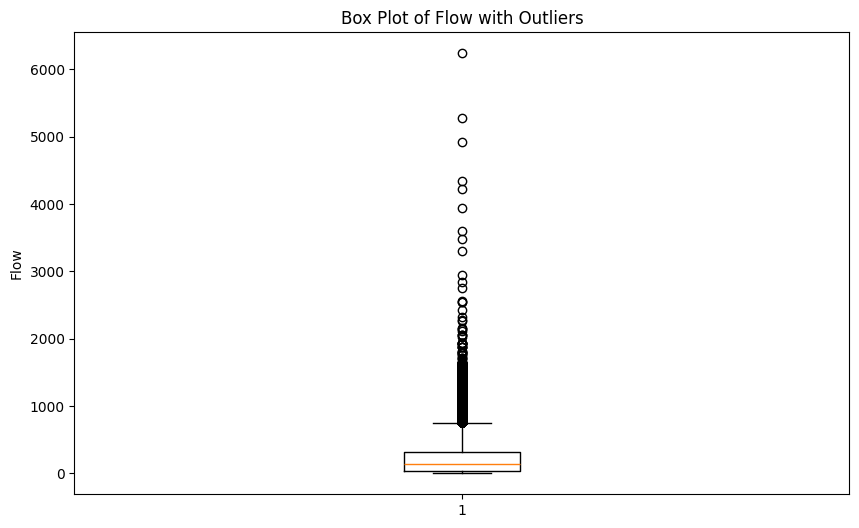

In [20]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['flow'])
plt.title('Box Plot of Flow with Outliers')
plt.ylabel('Flow')
plt.show()

**Reasoning**:
To visualize the identified outliers and the distribution of the 'occ' column, I will create a box plot. This will graphically represent the quartiles, IQR, and the data points that extend beyond the whiskers, which are considered outliers.



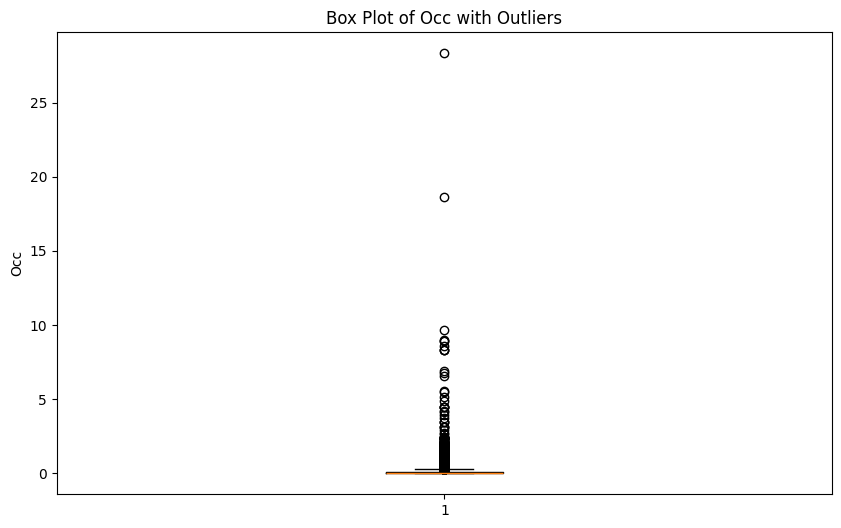

In [21]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['occ'])
plt.title('Box Plot of Occ with Outliers')
plt.ylabel('Occ')
plt.show()

## Outlier Treatment (Capping) untuk flow, occ

In [22]:
df['flow_capped'] = df['flow'].clip(lower=lower_bound, upper=upper_bound)
print(f"Original 'flow' min: {df['flow'].min()}, max: {df['flow'].max()}")
print(f"Capped 'flow_capped' min: {df['flow_capped'].min()}, max: {df['flow_capped'].max()}")

Original 'flow' min: 0.0, max: 6240.0
Capped 'flow_capped' min: 0.0, max: 740.0


In [23]:
df['occ_capped'] = df['occ'].clip(lower=lower_bound_occ, upper=upper_bound_occ)
print(f"Original 'occ' min: {df['occ'].min()}, max: {df['occ'].max()}")
print(f"Capped 'occ_capped' min: {df['occ_capped'].min()}, max: {df['occ_capped'].max()}")

Original 'occ' min: 0.0, max: 28.335556
Capped 'occ_capped' min: 0.0, max: 0.2624999993


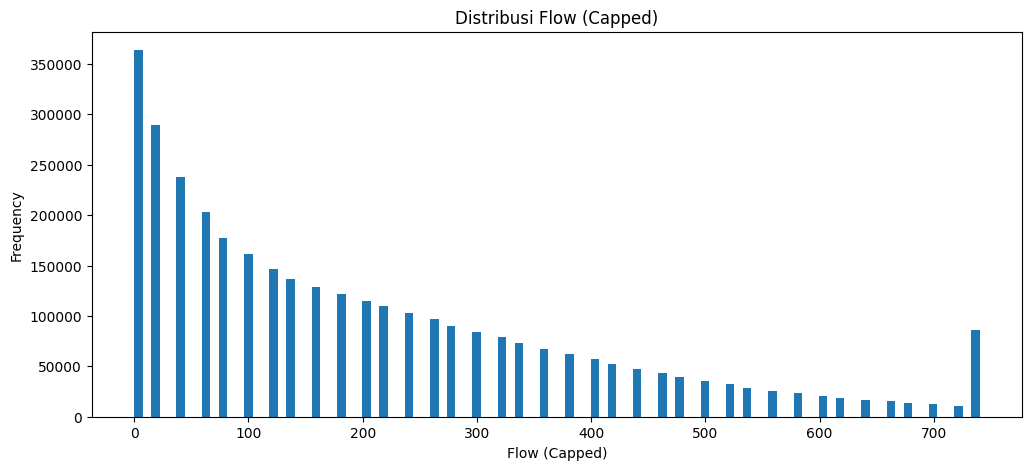

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.hist(df['flow_capped'], bins=100)
plt.title("Distribusi Flow (Capped)")
plt.xlabel("Flow (Capped)")
plt.ylabel("Frequency")
plt.show()

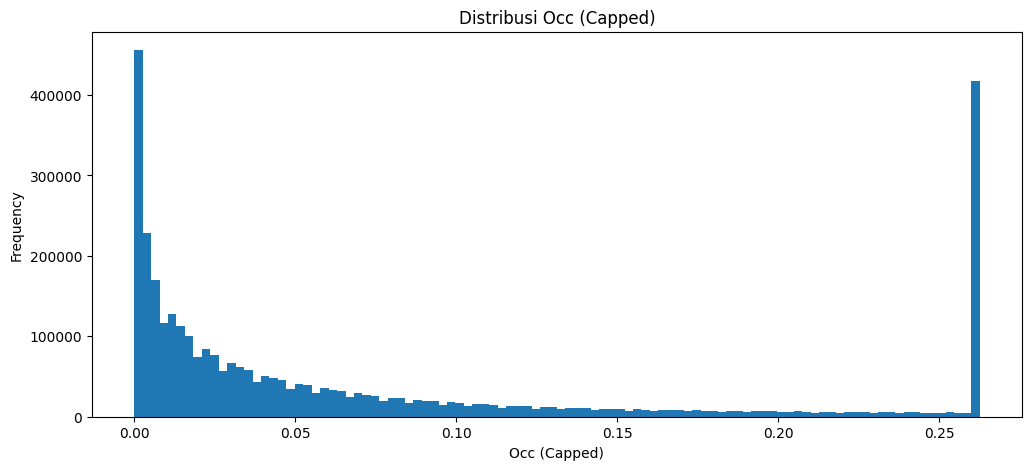

In [25]:
plt.figure(figsize=(12,5))
plt.hist(df['occ_capped'], bins=100)
plt.title("Distribusi Occ (Capped)")
plt.xlabel("Occ (Capped)")
plt.ylabel("Frequency")
plt.show()

## Verifikasi Hasil Capping

In [26]:
print("Statistik Deskriptif untuk 'flow_capped':")
print(df['flow_capped'].describe())

Statistik Deskriptif untuk 'flow_capped':
count    3.425002e+06
mean     2.040417e+02
std      1.913772e+02
min      0.000000e+00
25%      4.000000e+01
50%      1.400000e+02
75%      3.200000e+02
max      7.400000e+02
Name: flow_capped, dtype: float64


In [27]:
print("Statistik Deskriptif untuk 'occ_capped':")
print(df['occ_capped'].describe())

Statistik Deskriptif untuk 'occ_capped':
count    3.425002e+06
mean     7.496821e-02
std      8.934169e-02
min      0.000000e+00
25%      8.333334e-03
50%      3.333333e-02
75%      1.100000e-01
max      2.625000e-01
Name: occ_capped, dtype: float64


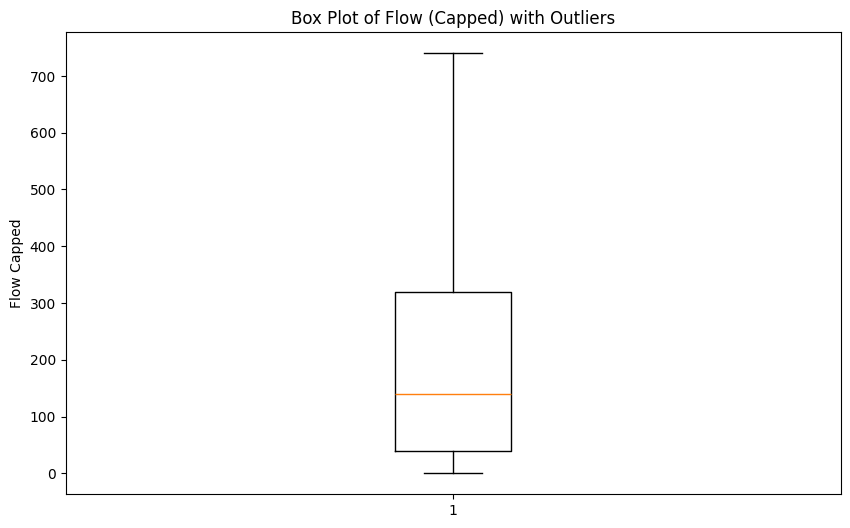

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(df['flow_capped'])
plt.title('Box Plot of Flow (Capped) with Outliers')
plt.ylabel('Flow Capped')
plt.show()

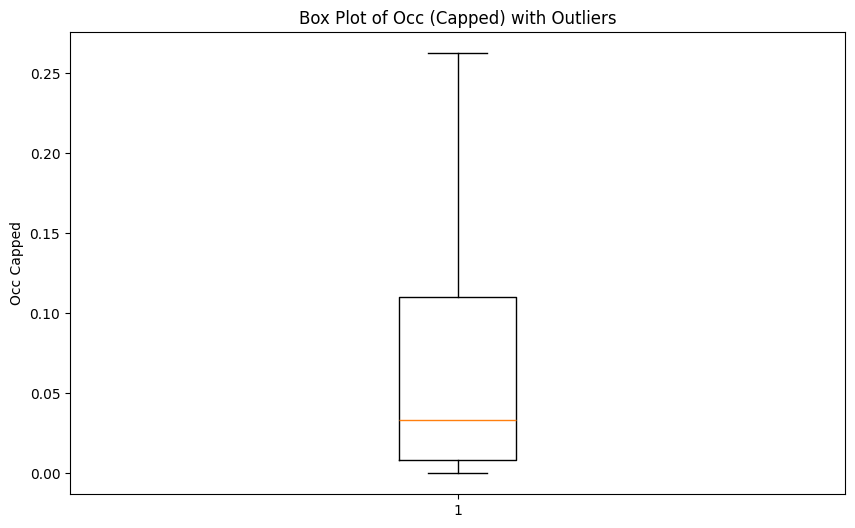

In [29]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['occ_capped'])
plt.title('Box Plot of Occ (Capped) with Outliers')
plt.ylabel('Occ Capped')
plt.show()

# Klasifikasi Macet/Lancar

Mendefinisikan target variabel


In [30]:
df['traffic_status'] = np.where(df['occ_capped'] > 0.1, 'macet', 'lancar')
print(df[['occ_capped', 'traffic_status']].head(500))

#INI HANYA UNTUK TESTING(TIDAK JADI DIGUNAKAN PADA X TRAIN/TEST)

     occ_capped traffic_status
0      0.005556         lancar
1      0.000000         lancar
2      0.007778         lancar
3      0.008333         lancar
4      0.000000         lancar
..          ...            ...
495    0.002778         lancar
496    0.003889         lancar
497    0.010556         lancar
498    0.000000         lancar
499    0.000000         lancar

[500 rows x 2 columns]


OCC Tidak jadi digunakan karena Target Leakage

 Definisi: Mendefinisikan "macet" sebagai $occ \ge 0.11$.Kebocoran: kemudian memberikan kolom $occ$ (atau $occ\_capped$) sebagai fitur ke model.Hasil: Model tidak belajar memprediksi macet; ia hanya melihat fitur $occ$ dan langsung tahu jawabannya dengan kepastian $100\%$ karena jawabannya sudah terkandung dalam fitur.

# Training (RandomForest)

In [31]:
X = df[['flow_capped']]
y = df['traffic_status']

print("Features (X) head after revision:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())

Features (X) head after revision:
   flow_capped
0         40.0
1          0.0
2         40.0
3         40.0
4          0.0

Target (y) head:
0    lancar
1    lancar
2    lancar
3    lancar
4    lancar
Name: traffic_status, dtype: object


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape after revision: {X_train.shape}")
print(f"X_test shape after revision: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape after revision: (2740001, 1)
X_test shape after revision: (685001, 1)
y_train shape: (2740001,)
y_test shape: (685001,)


In [33]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("RandomForestClassifier model retrained successfully with revised features.")

RandomForestClassifier model retrained successfully with revised features.


# Testing & Evaluasi

In [34]:


y_pred = model.predict(X_test)

accuracy_revised = accuracy_score(y_test, y_pred)
print(f"Accuracy after feature revision: {accuracy_revised:.4f}")

print("\nClassification Report after feature revision:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix after feature revision:")
print(confusion_matrix(y_test, y_pred))

Accuracy after feature revision: 0.7763

Classification Report after feature revision:
              precision    recall  f1-score   support

      lancar       0.80      0.93      0.86    501937
       macet       0.64      0.37      0.47    183064

    accuracy                           0.78    685001
   macro avg       0.72      0.65      0.66    685001
weighted avg       0.76      0.78      0.75    685001


Confusion Matrix after feature revision:
[[464486  37451]
 [115786  67278]]


Jadi, terlihat bahwa kelas macet memiliki akurasi lebih rendah karena datanya hanya 183064, berbanding terbalik dengan kelas lancar

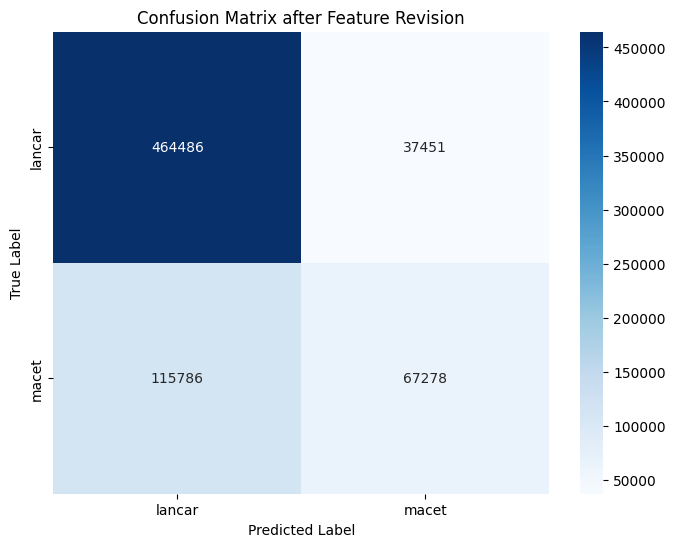

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['lancar', 'macet'], yticklabels=['lancar', 'macet'])
plt.title('Confusion Matrix after Feature Revision')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

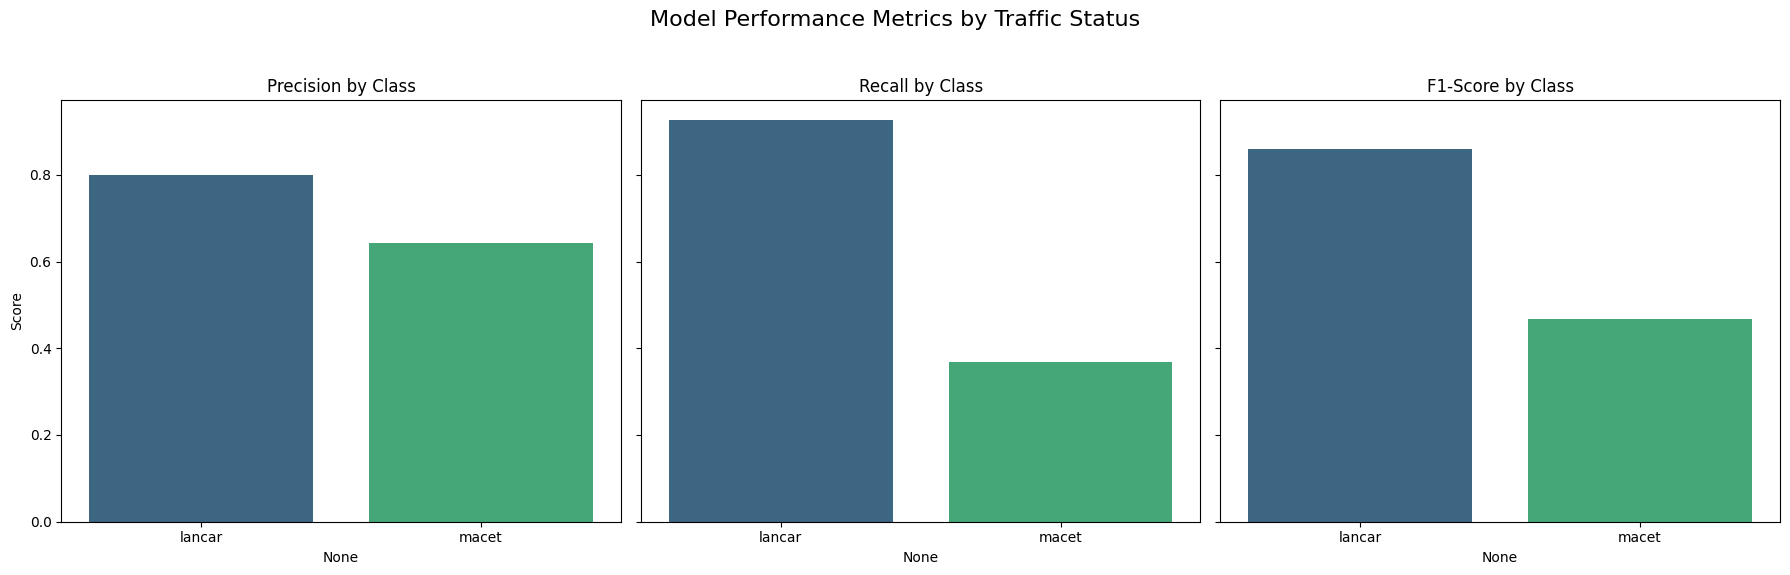

In [36]:
report = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame(report).transpose()

df_report = df_report.loc[['lancar', 'macet']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.barplot(x=df_report.index, y='precision', data=df_report, ax=axes[0], palette='viridis', hue=df_report.index, legend=False)
axes[0].set_title('Precision by Class')
axes[0].set_ylabel('Score')

sns.barplot(x=df_report.index, y='recall', data=df_report, ax=axes[1], palette='viridis', hue=df_report.index, legend=False)
axes[1].set_title('Recall by Class')
axes[1].set_ylabel('Score')

sns.barplot(x=df_report.index, y='f1-score', data=df_report, ax=axes[2], palette='viridis', hue=df_report.index, legend=False)
axes[2].set_title('F1-Score by Class')
axes[2].set_ylabel('Score')

plt.suptitle('Model Performance Metrics by Traffic Status', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Training (K-Nearest Neighbors)

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

print("K-Nearest Neighbors model trained successfully.")

K-Nearest Neighbors model trained successfully.


## Testing & Evaluasi (K-Nearest Neighbors)

In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy for KNN model: {accuracy_knn:.4f}")

print("\nClassification Report for KNN model:")
print(classification_report(y_test, y_pred_knn))

print("\nConfusion Matrix for KNN model:")
print(confusion_matrix(y_test, y_pred_knn))

Accuracy for KNN model: 0.7599

Classification Report for KNN model:
              precision    recall  f1-score   support

      lancar       0.80      0.89      0.84    501937
       macet       0.57      0.40      0.47    183064

    accuracy                           0.76    685001
   macro avg       0.69      0.65      0.66    685001
weighted avg       0.74      0.76      0.74    685001


Confusion Matrix for KNN model:
[[447579  54358]
 [110118  72946]]


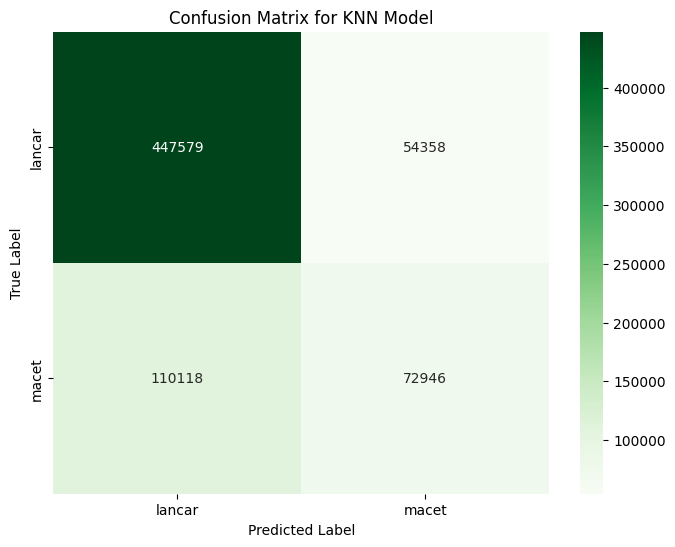

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', xticklabels=['lancar', 'macet'], yticklabels=['lancar', 'macet'])
plt.title('Confusion Matrix for KNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

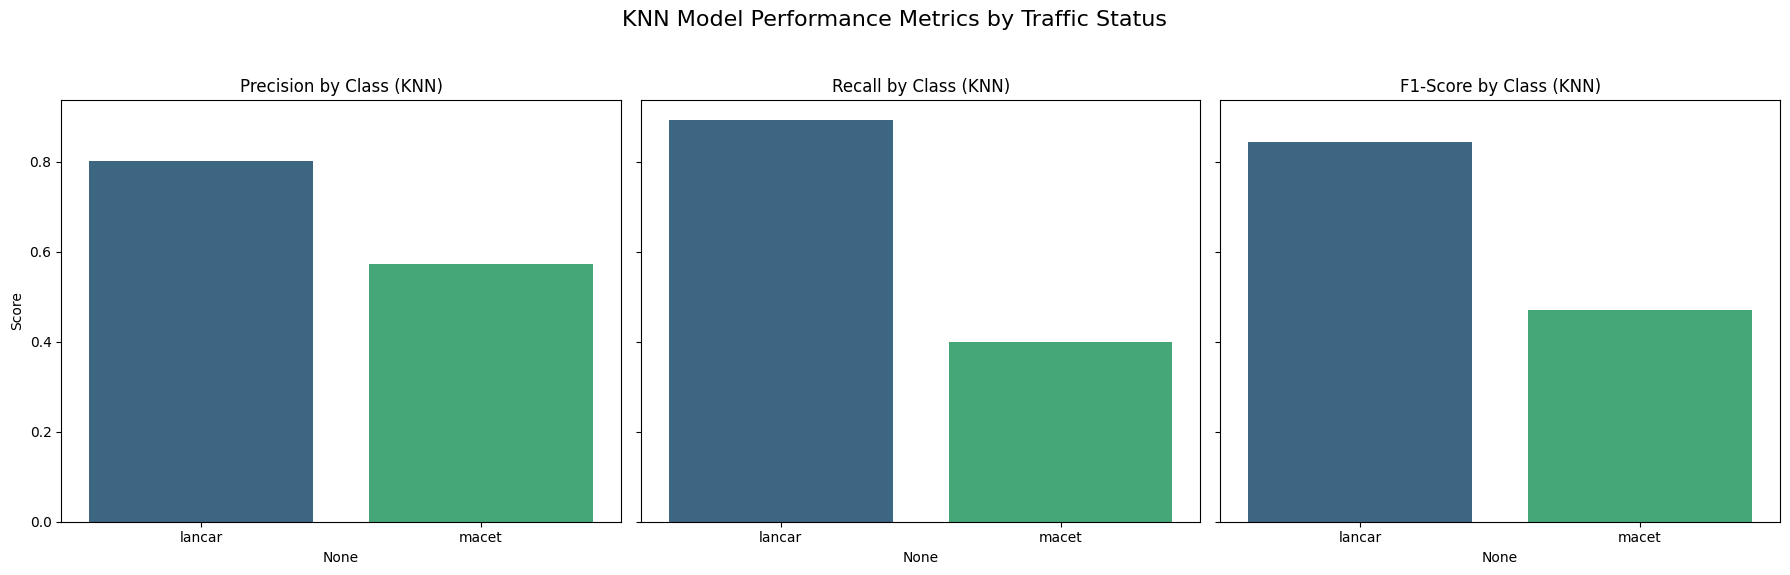

In [40]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

report_knn = classification_report(y_test, y_pred_knn, output_dict=True)

df_report_knn = pd.DataFrame(report_knn).transpose()
df_report_knn = df_report_knn.loc[['lancar', 'macet']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.barplot(x=df_report_knn.index, y='precision', data=df_report_knn, ax=axes[0], palette='viridis', hue=df_report_knn.index, legend=False)
axes[0].set_title('Precision by Class (KNN)')
axes[0].set_ylabel('Score')

sns.barplot(x=df_report_knn.index, y='recall', data=df_report_knn, ax=axes[1], palette='viridis', hue=df_report_knn.index, legend=False)
axes[1].set_title('Recall by Class (KNN)')
axes[1].set_ylabel('Score')

sns.barplot(x=df_report_knn.index, y='f1-score', data=df_report_knn, ax=axes[2], palette='viridis', hue=df_report_knn.index, legend=False)
axes[2].set_title('F1-Score by Class (KNN)')
axes[2].set_ylabel('Score')

plt.suptitle('KNN Model Performance Metrics by Traffic Status', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Model Comparison


Model Performance Comparison:
                    RandomForest  K-Nearest Neighbors
Metric                                               
Accuracy                0.776297             0.759889
F1-Score (Macet)        0.467544             0.470061
 F1-Score (Lancar)      0.858404             0.844780


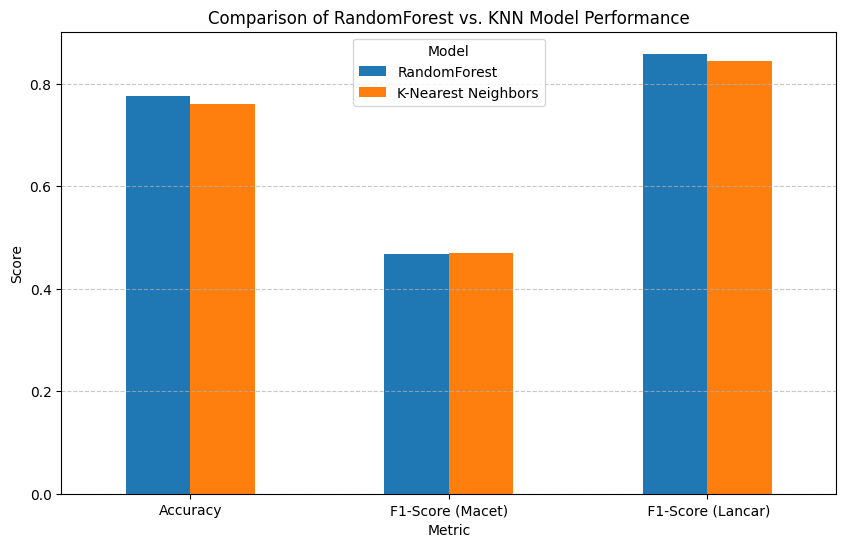

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

report_rf = classification_report(y_test, y_pred, output_dict=True)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)


accuracy_rf = report_rf['accuracy']
accuracy_knn = report_knn['accuracy']

f1_macet_rf = report_rf['macet']['f1-score']
f1_lancar_rf = report_rf['lancar']['f1-score']
f1_macet_knn = report_knn['macet']['f1-score']
f1_lancar_knn = report_knn['lancar']['f1-score']


comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score (Macet)',' F1-Score (Lancar)']
}).set_index('Metric')

comparison_df['RandomForest'] = [accuracy_rf, f1_macet_rf,f1_lancar_rf]
comparison_df['K-Nearest Neighbors'] = [accuracy_knn, f1_macet_knn,f1_lancar_knn]

print("\nModel Performance Comparison:")
print(comparison_df)

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of RandomForest vs. KNN Model Performance')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
df['flow'].describe()

count    3.425002e+06
mean     2.074920e+02
std      2.031532e+02
min      0.000000e+00
25%      4.000000e+01
50%      1.400000e+02
75%      3.200000e+02
max      6.240000e+03
Name: flow, dtype: float64